# Pancreas endocrinogenesis E1415 - scVelo

### Imports and Settings

In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import scvelo as scv
import cellrank as cr
import anndata as ad
from cellrank.kernels import ConnectivityKernel, VelocityKernel
from cellrank.estimators import GPCCA
#from tueplots import bundles
#from tueplots import axes

In [2]:
cr.logging.print_versions()

cellrank==1.5.1+g525b847 scanpy==1.9.1 anndata==0.8.0 numpy==1.23.5 numba==0.56.4 scipy==1.10.0 pandas==1.5.2 pygpcca==1.0.4 scikit-learn==1.2.0 statsmodels==0.13.5 scvelo==0.2.5 pygam==0.8.0 matplotlib==3.6.2 seaborn==0.12.2


## Data Loading and Preprocessing

In [3]:
adata145 = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/pancreas/day_14.5_growth_rate.h5ad")
adata155 = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/pancreas/day_15.5_growth_rate.h5ad")
adata = ad.concat([adata145, adata155])

adata.obsp = {}
adata.uns = {}
adata.obsm = {}
adata.varm = {}
adata.obs = adata.obs.loc[:, ['day', 'celltype']]
adata.var = adata.var[[]]

adata

AnnData object with n_obs × n_vars = 20519 × 16206
    obs: 'day', 'celltype'
    layers: 'spliced', 'unspliced'

In [4]:
adata_fourteen = adata[adata.obs['day'] == 14.5, :].copy()
adata_fiveteen = adata[adata.obs['day'] == 15.5, :].copy()

In [5]:
scv.pp.pca(adata_fourteen, n_comps=50)
scv.pp.pca(adata_fiveteen, n_comps=50)
scv.pp.moments(adata_fourteen)
scv.pp.moments(adata_fiveteen)

Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:45) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:09) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:09) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
sc.tl.umap(adata_fourteen)
sc.tl.umap(adata_fiveteen)

## RNA Velocity Estimation

In [7]:
scv.tl.recover_dynamics(adata_fourteen, n_jobs=10)
scv.tl.velocity(adata_fourteen, mode='dynamical')

recovering dynamics (using 10/96 cores)
or disable the progress bar using `show_progress_bar=False`.


/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the ex

KeyboardInterrupt: 

In [ ]:
scv.tl.recover_dynamics(adata_fiveteen, n_jobs=10)
scv.tl.velocity(adata_fiveteen, mode='dynamical')

## Concatenate timepoints 14 and 15

In [ ]:
adata = ad.concat([adata_fourteen, adata_fiveteen])

In [ ]:
old_adata = ad.concat([adata145, adata155], merge="same")
sc.pp.neighbors(old_adata)

In [ ]:
adata.obsm["X_pca"] = old_adata.obsm["X_pca"].copy()
adata.obsm["X_umap"] = old_adata.obsm["X_umap"].copy()
adata.obs["clusters"] = old_adata.obs["celltype"].copy()
adata.uns["neighbors"] = old_adata.uns["neighbors"].copy()
adata.obsp["connectivities"] = old_adata.obsp["connectivities"].copy()
adata.obsp["distances"] = old_adata.obsp["distances"].copy()

In [ ]:
scv.set_figure_params('scvelo', transparent=True, fontsize=10, color_map='viridis')
scv.pl.scatter(adata,  color_map='viridis')

In [3]:
adata = sc.read("/home/icb/jonas.flor/precomputed_data/scvelo_pan_pre.h5ad")

# Cellrank

### Transition probabilities

In [4]:
vk = VelocityKernel(adata).compute_transition_matrix()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20519/20519 [00:23<00:00, 889.55cell/s]


### Macrostate calculation

In [5]:
g = GPCCA(vk)

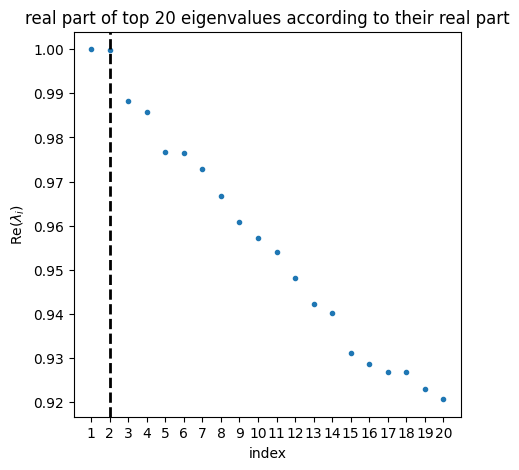

In [6]:
g.compute_schur(n_components=20)
g.plot_spectrum(real_only=True)

/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


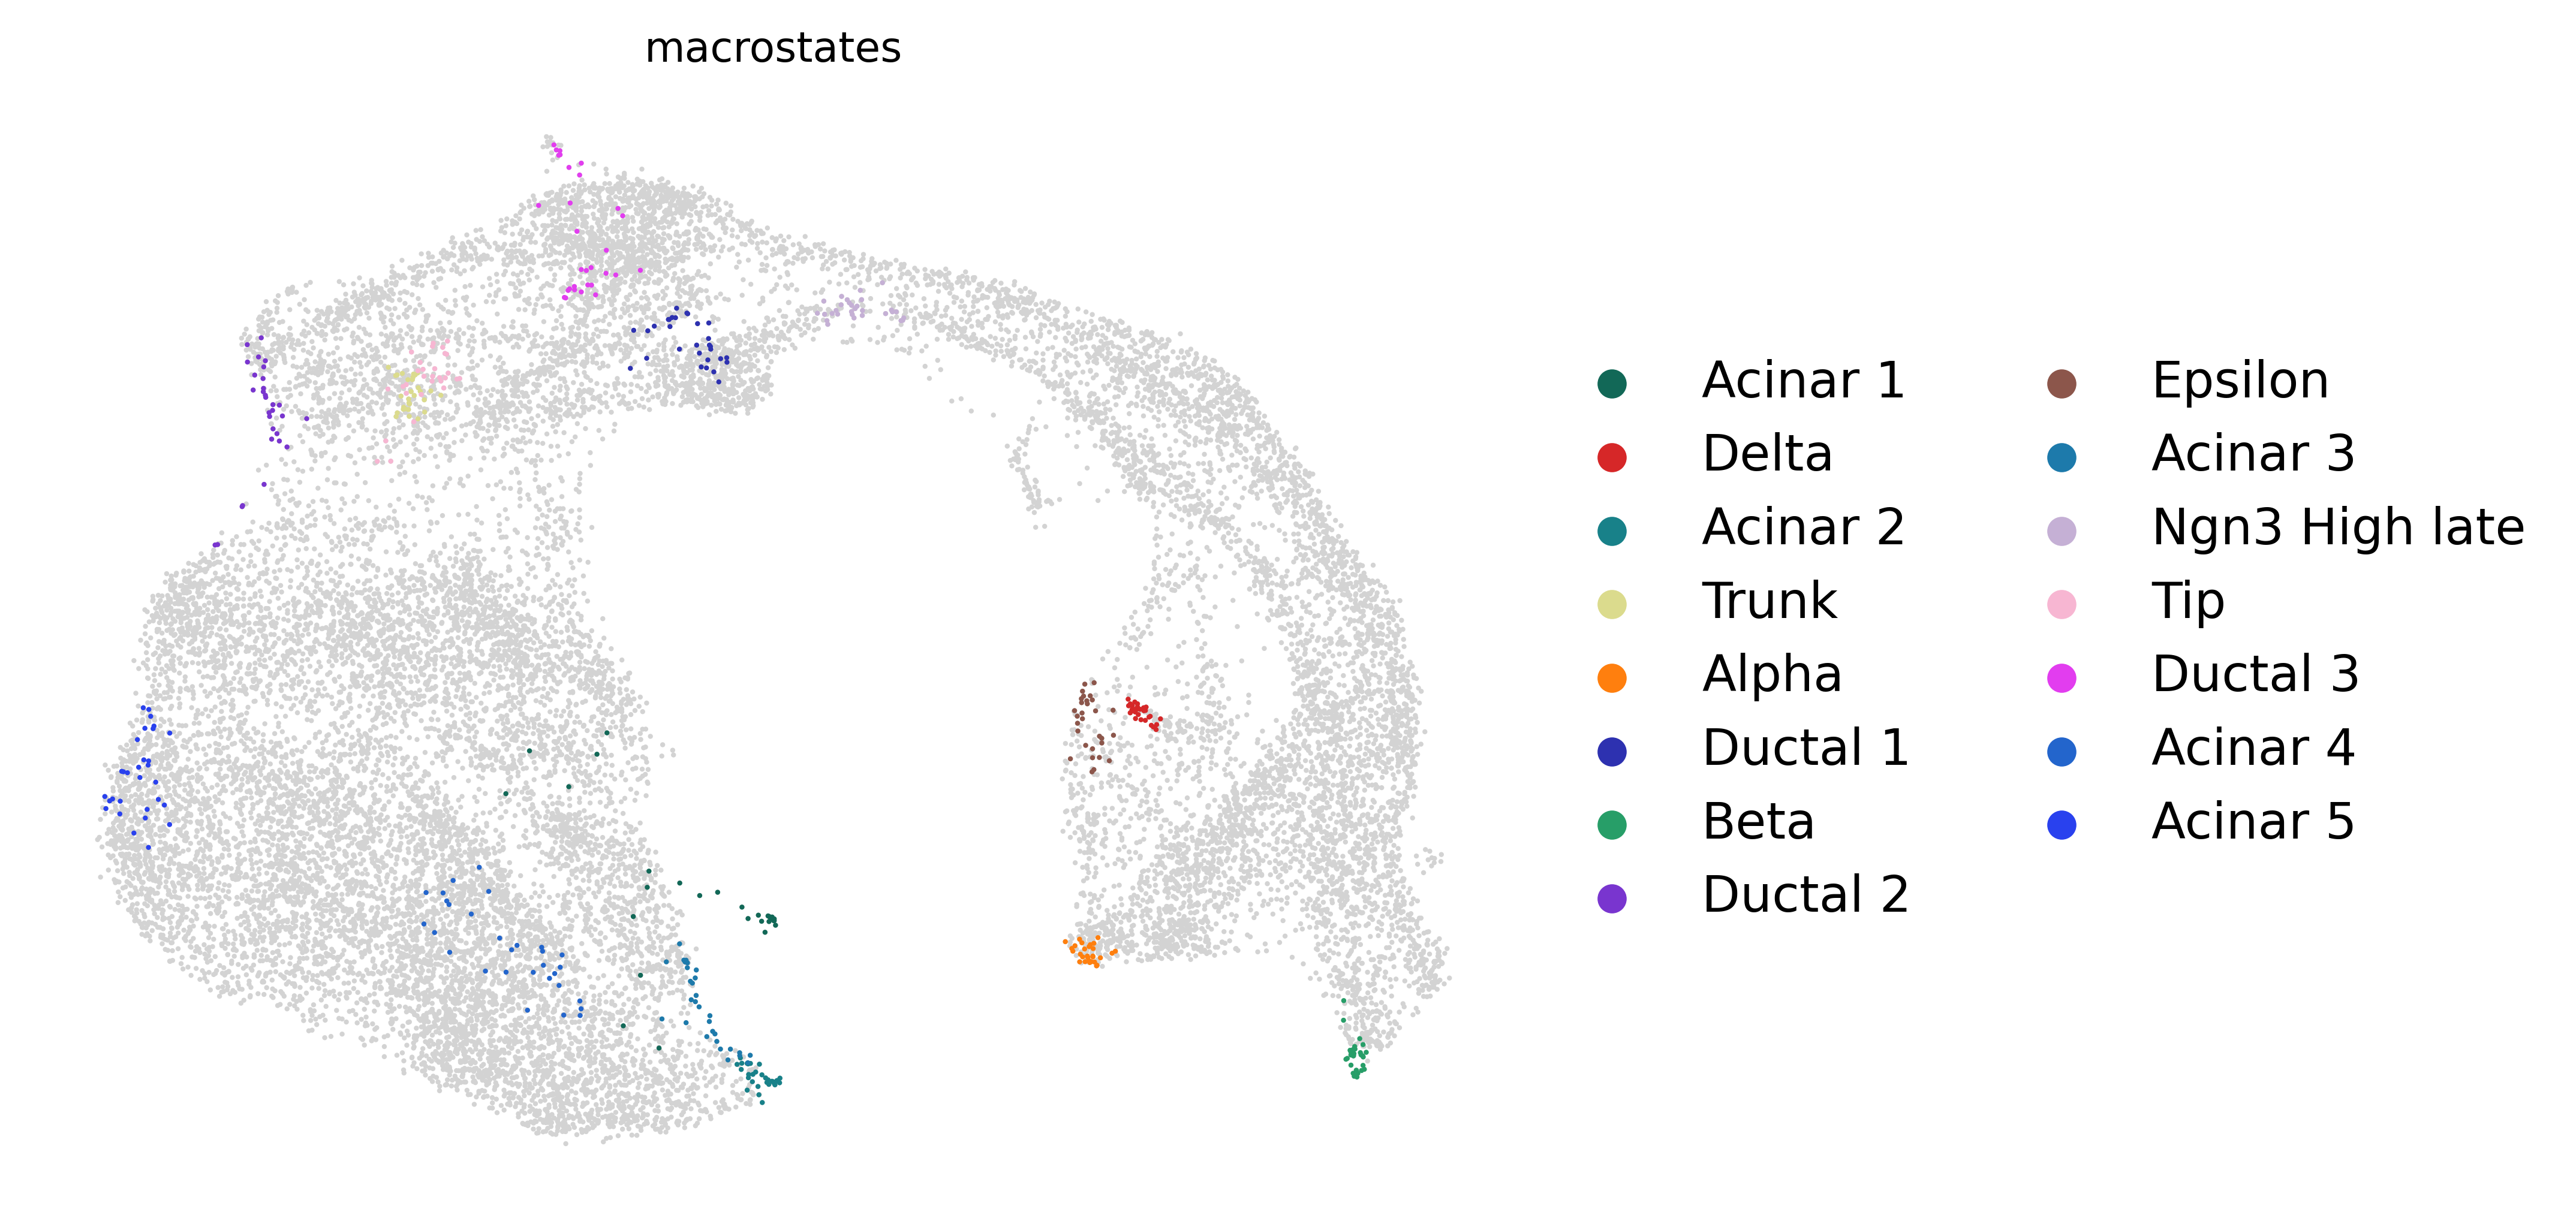

In [7]:
g.compute_macrostates(n_states=15, cluster_key="celltype")
scv.set_figure_params('scvel o', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

### Fate probabilities

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.79/s]
/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


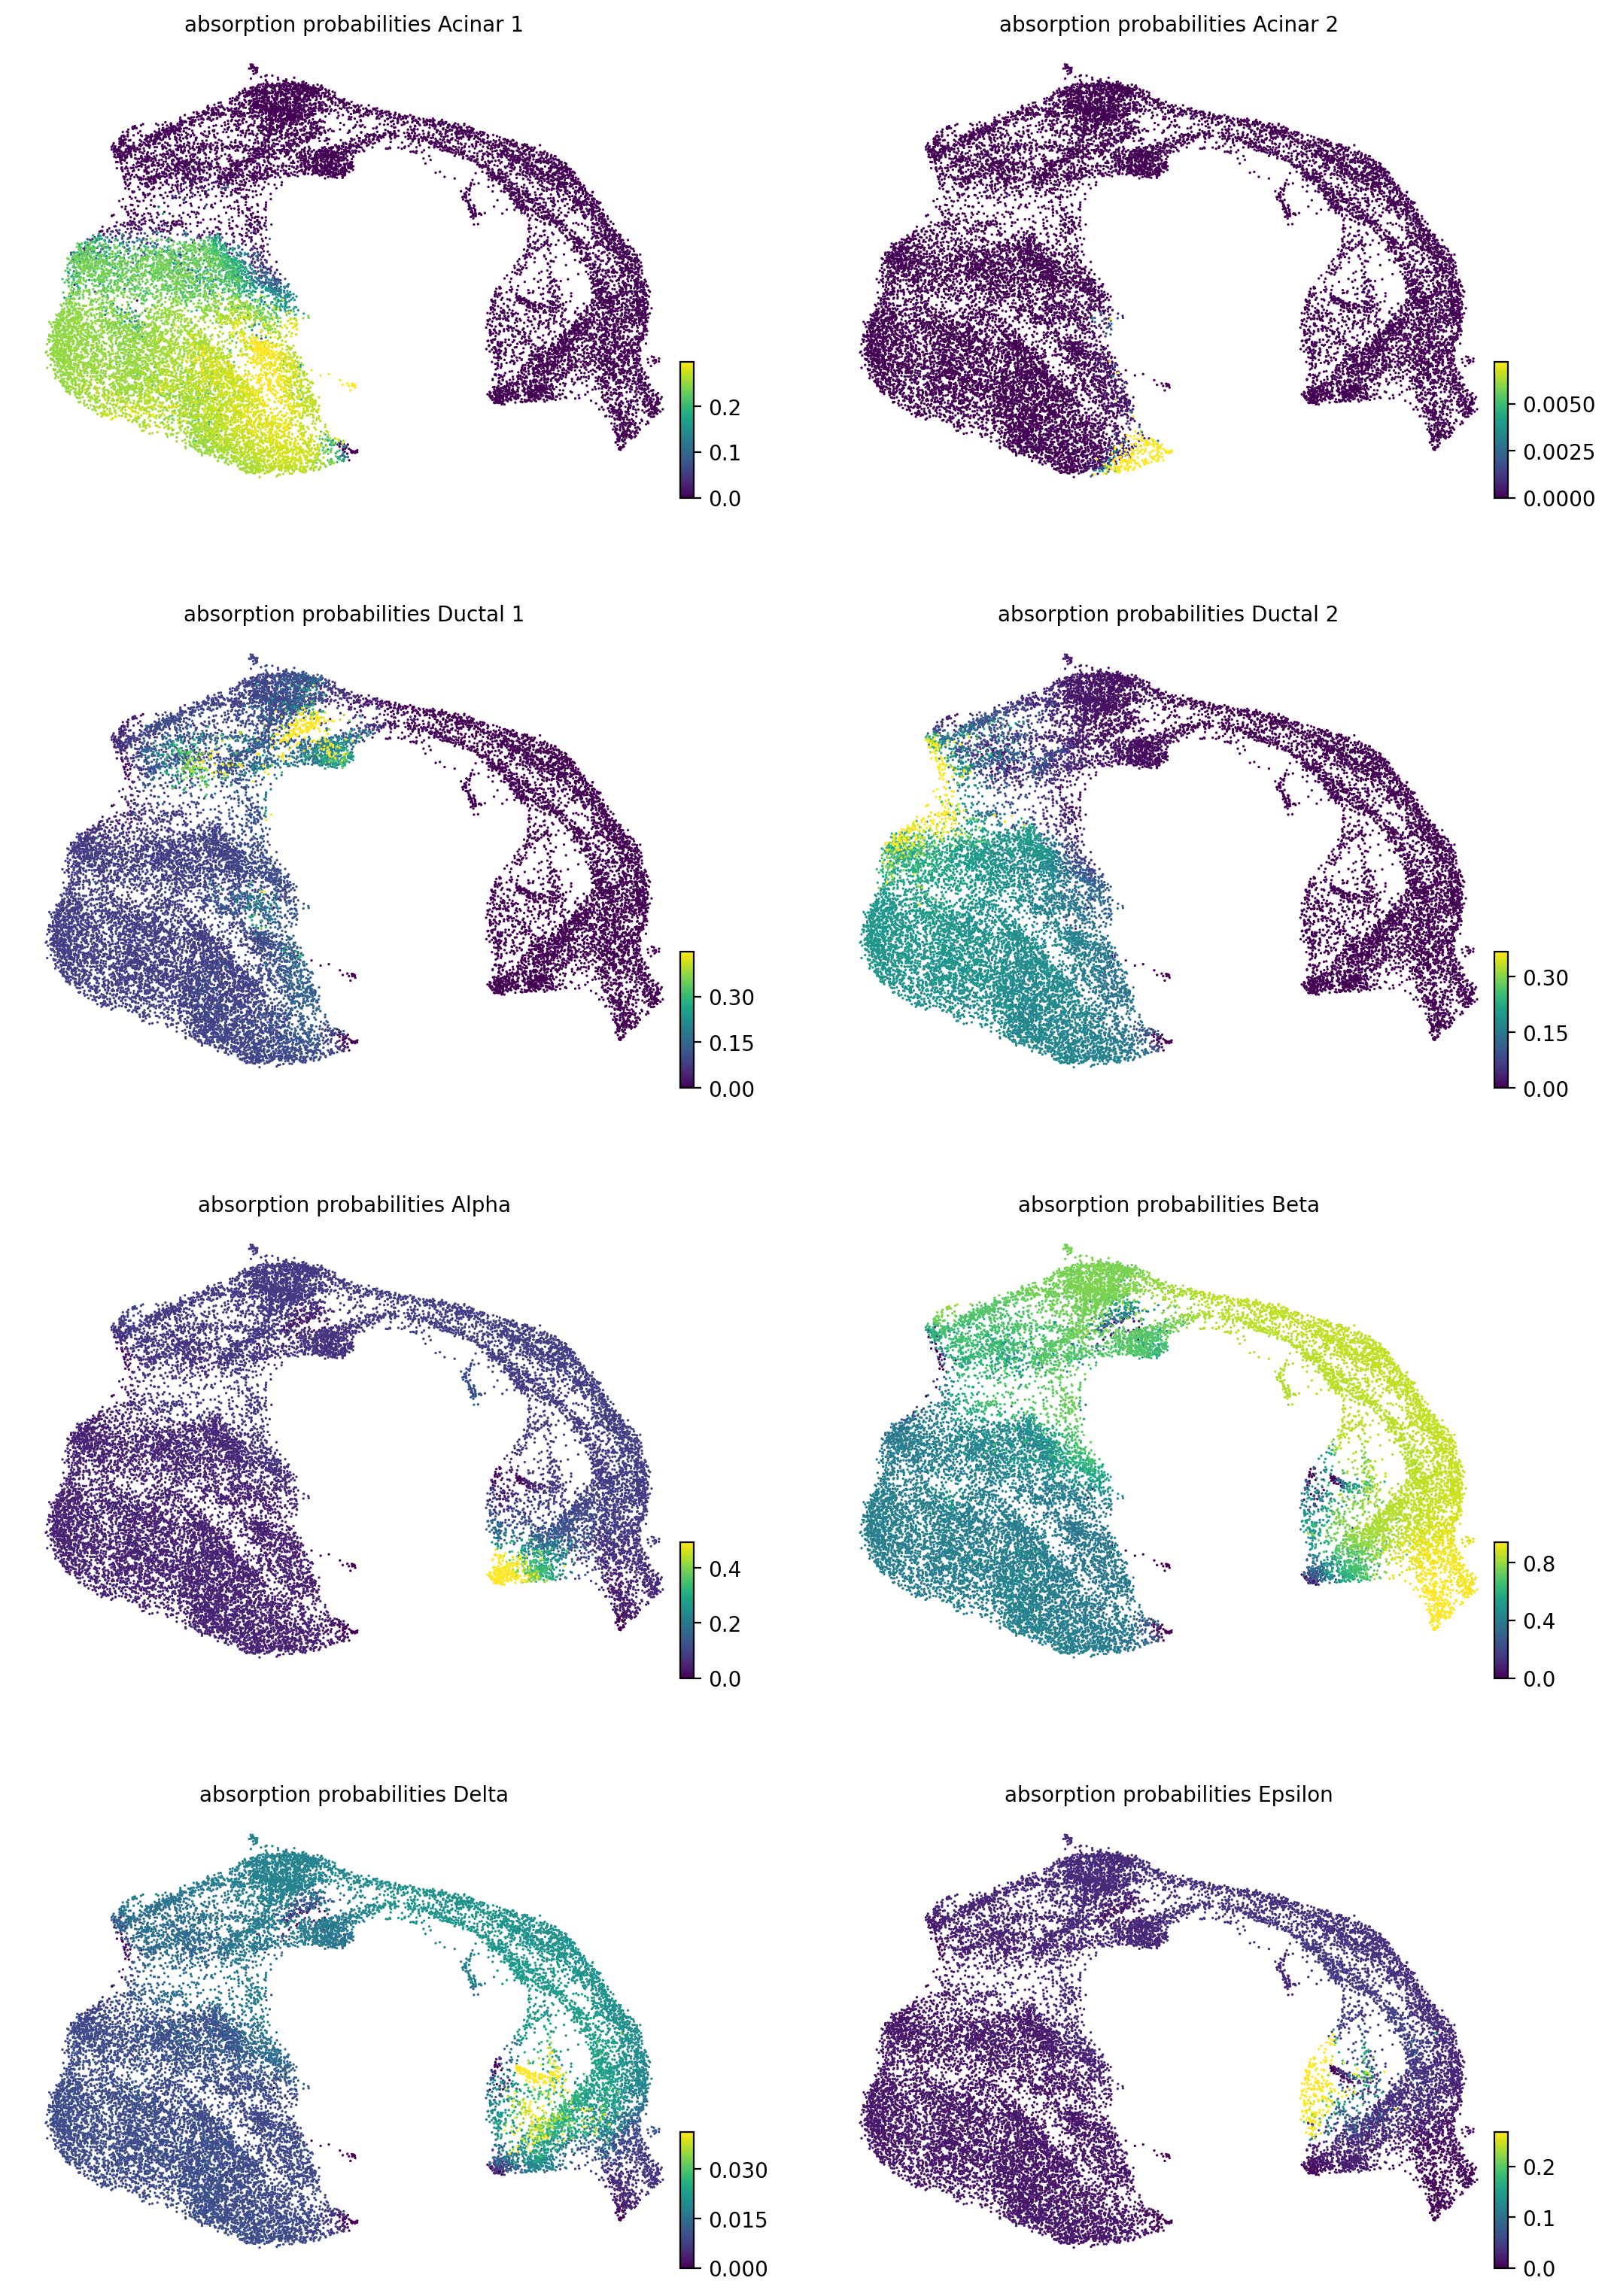

In [8]:
g.set_terminal_states_from_macrostates(
    [
        "Acinar_1", "Acinar_2", "Ductal_1", "Ductal_2", "Alpha", "Beta", "Delta", "Epsilon" 
    ]
)
g.compute_absorption_probabilities(solver="gmres", use_petsc=True, tol=1e-12, preconditioner='ilu')
g.plot_absorption_probabilities(same_plot=False, basis="umap", perc=[0, 99], ncols=2)

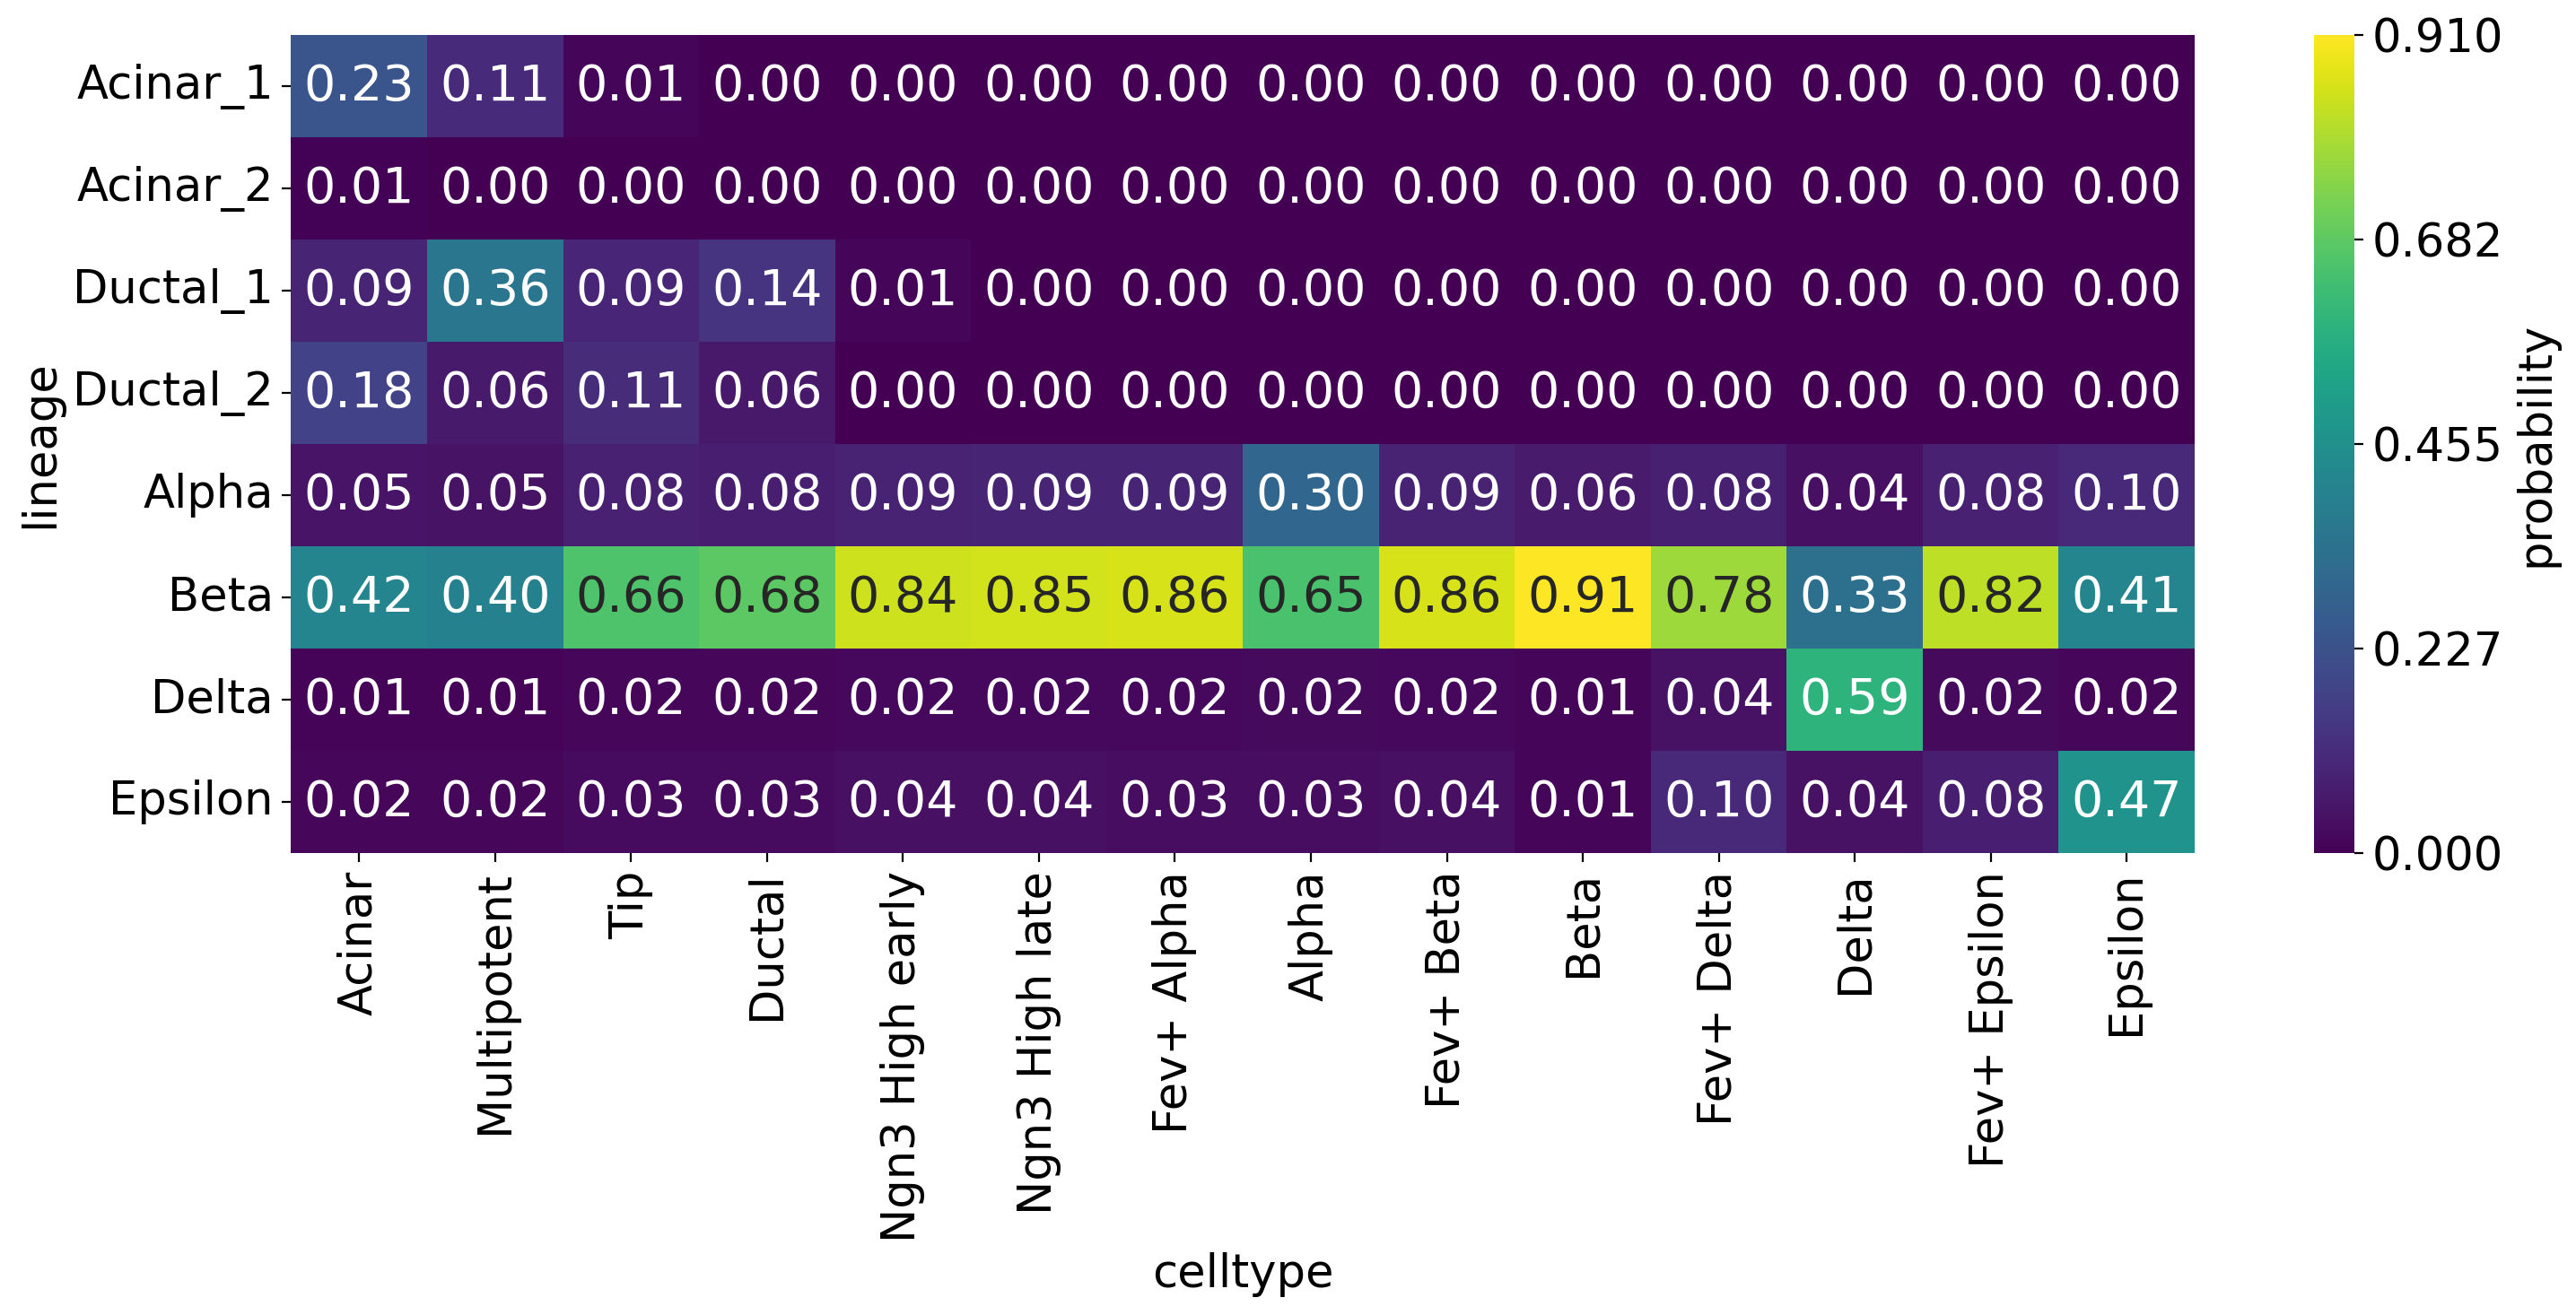

In [9]:
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
cr.pl.aggregate_absorption_probabilities(
    adata,
    mode='heatmap',
    lineages=["Acinar_1", "Acinar_2", "Ductal_1", "Ductal_2", "Alpha", "Beta", "Delta", "Epsilon" ],
    cluster_key='celltype',
    clusters=['Acinar', 'Multipotent', 'Tip', 'Ductal', 'Ngn3 High early', 'Ngn3 High late', 'Fev+ Alpha', 'Alpha', 'Fev+ Beta', 'Beta', 'Fev+ Delta', 'Delta', 'Fev+ Epsilon', 'Epsilon'],
    figsize=(17, 6),
    title="",
    save="transprobs_pancreas1415_scvelo.png"
)

### Velocity Stream Plot

computing velocity embedding
    finished (0:00:04) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 600x400 with 0 Axes>

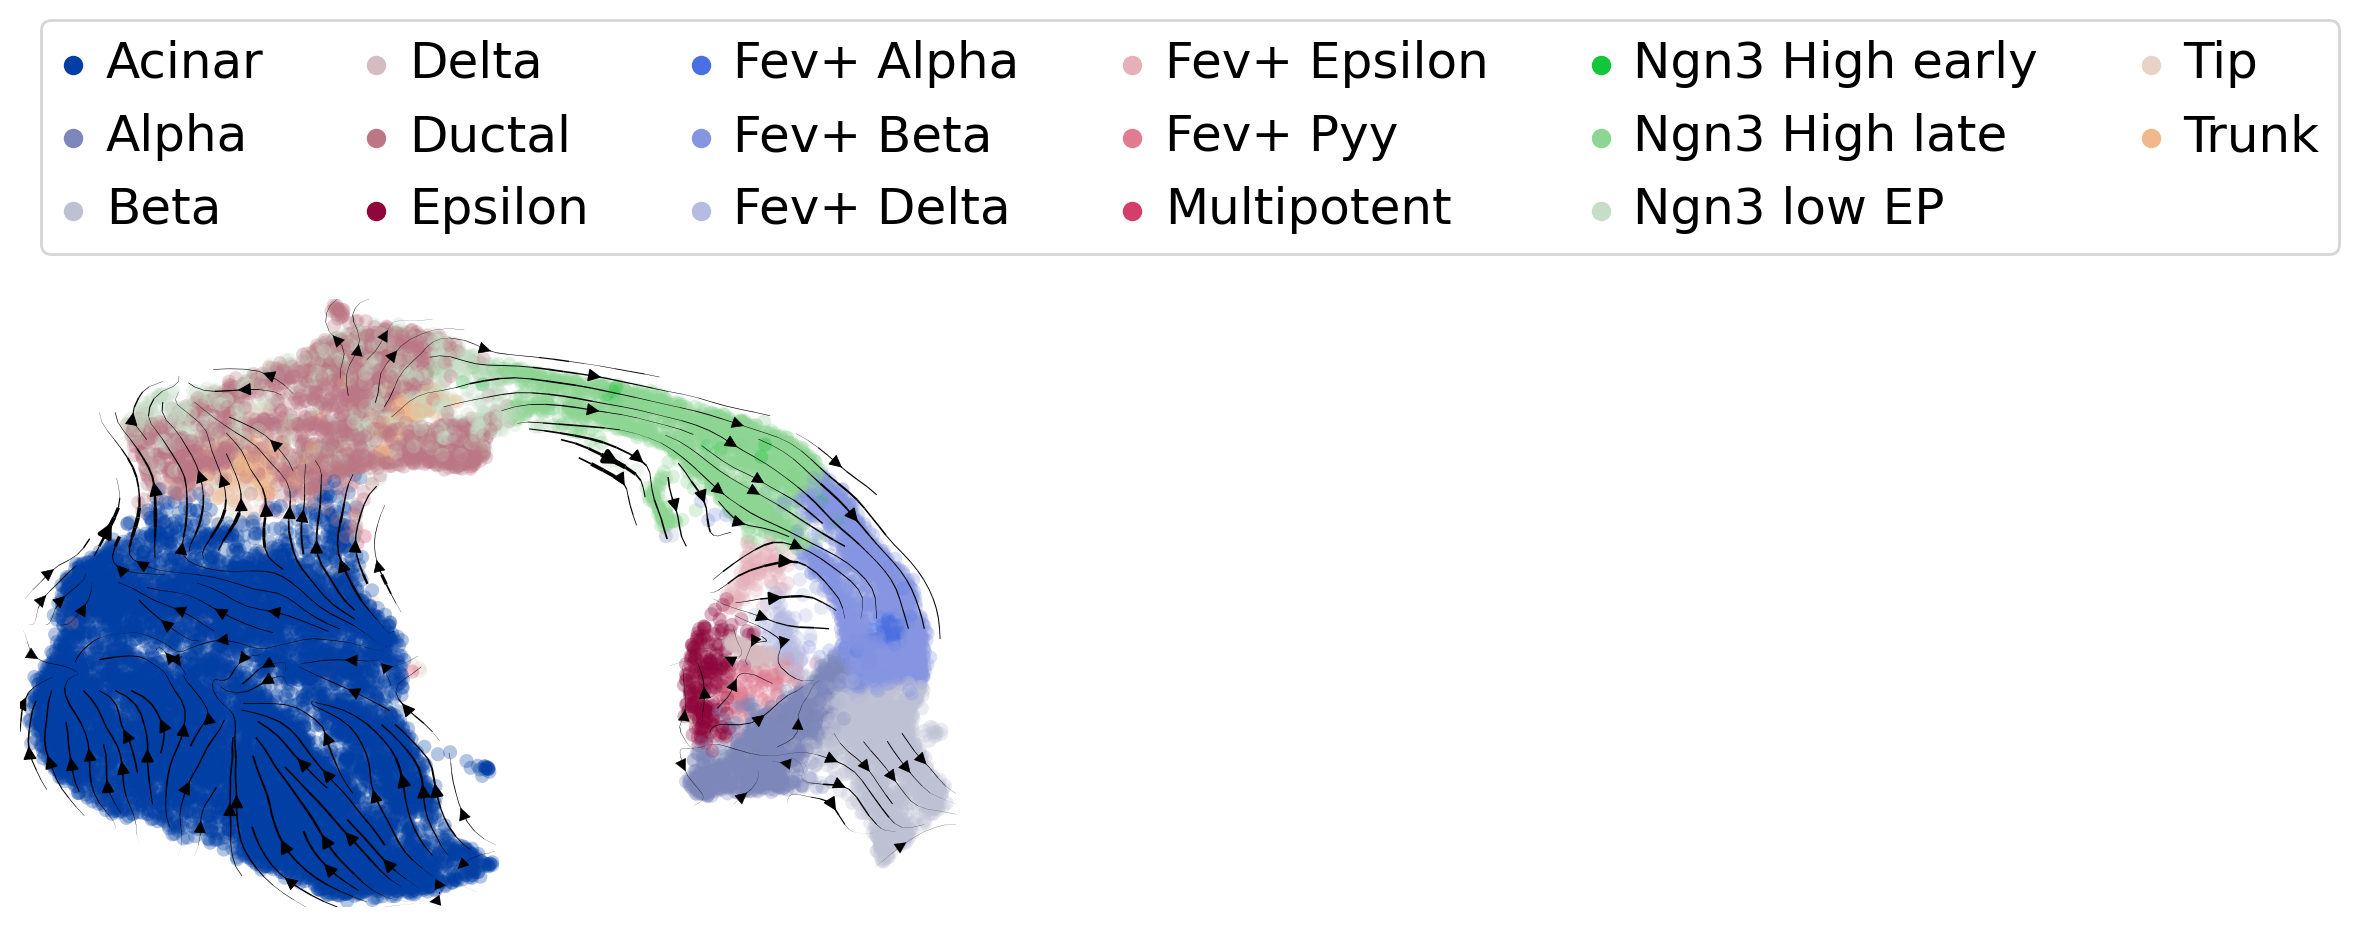

In [10]:
adata.uns["velocity_graph"] = vk.transition_matrix

scv.set_figure_params('scvelo', transparent=True, fontsize=10, dpi_save=400,color_map='viridis')
fig = plt.figure()
ax = scv.pl.velocity_embedding_stream(adata, basis="umap", smooth=0.5, title="", legend_loc="none", show=False)
legend =ax.legend(bbox_to_anchor=[1.25, 1.5], loc='upper center', ncol=6,frameon=True, prop={'size': 18})
#plt.savefig("velstream_pancreas1415_scvelo", dpi=800, bbox_inches='tight')

In [11]:
scv.tl.velocity_confidence(adata)

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


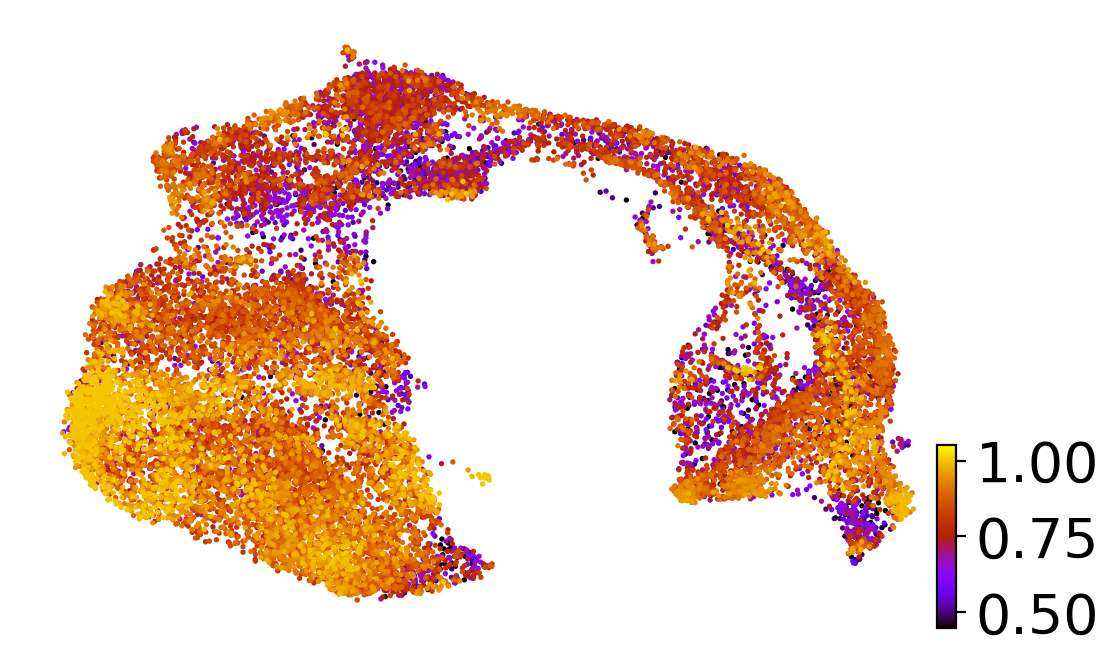

In [12]:
scv.set_figure_params('scvelo', fontsize=20)
scv.settings.presenter_view = False
scv.pl.scatter(adata, color='velocity_confidence',
               perc=[2, 98],
               cmap='gnuplot',
               vmid=0.75,
               rescale_color=[0.5, 1.0],
               size=15,
               title="",
               #save="velconf_pancreas1415_scvelo.png"
              )

In [ ]:
#adata.write("adata_results/pancreas1415_scvelo.h5ad")

In [18]:
#adata.write("/home/icb/jonas.flor/precomputed_data/scvelo_pan_pre.h5ad")